In [ ]:
pip install d2l # Note: If prompted to restart, please do so and run the proceeding cells.

In [ ]:
# Imports
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.io import read_image
from torchvision import datasets, transforms
import warnings
import zipfile
from tqdm import tqdm
import os
from pathlib import Path
import random
from PIL import Image, ImageDraw
from IPython.display import display
warnings.filterwarnings('ignore')

from torch import nn
from d2l import torch as d2l

In [ ]:
# Extracting the data
filename = '/content/smoke-fire-detection-yolo.zip' # Note that filename might be different depending on the device, this one should work for google colab.
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('../content/')

In [ ]:
# Because of the unique way that the data is structured, we will have to create a custom dataset for training.
class RCNNDataset(Dataset): # Inherits from torch.utils.data.Dataset
  def __init__(self, img_dir, label_dir, transform=None):
    self.img_dir = img_dir
    self.label_dir = label_dir
    self.transform = transform
    self.img_files = sorted(os.listdir(img_dir)) # Sorting so the order remains the same
    self.label_files = sorted(os.listdir(label_dir))

    # Keep only the images that have existing labels
    self.valid_files = []
    for img_file, label_file in zip(self.img_files, self.label_files):
      label_path = os.path.join(label_dir, label_file)
      if os.path.getsize(label_path) > 1:  # Skip empty labels
        self.valid_files.append((img_file, label_file))

  def __len__(self): # Needed for determining the size of the dataset
    return len(self.valid_files)

  def __getitem__(self, idx): # Used to get items
    img_file, label_file = self.valid_files[idx]

    # Getting image
    img_path = os.path.join(self.img_dir, img_file)
    img = Image.open(img_path).convert("RGB")

    # Getting bounding boxes
    label_path = os.path.join(self.label_dir, label_file)
    with open(label_path, 'r') as f:
      boxes, labels = [], []
      for line in f:
        x_center, y_center, w, h = list(map(float, line.strip().split()))[1:]
        label = list(map(float, line.strip().split()))[0]

        # Convert proportions to pixel values
        img_w, img_h = img.size
        x = (x_center - w / 2) * img_w
        y = (y_center - h / 2) * img_h
        w = w * img_w
        h = h * img_h
        boxes.append([x, y, x + w, y + h])
        labels.append(label)

      # Check for invalid box proportions and skip the image if found. Added to avoid error
      for box in boxes:
        if box[2] - box[0] <= 0 or box[3] - box[1] <= 0:
          print(f"Skipping image {img_path} because box: {box} proportions are invalid")
          # if there's an invalid box we skip by calling this method again but with the next image
          return self.__getitem__((idx + 1)%self.__len__()) # should return index of the next item because index+1 divided by total length will return index+1, but if index is greater than length, it will return index 0

      # Convert to Torch Tensors
      boxes = torch.tensor(boxes, dtype=torch.float32)
      labels = torch.tensor(labels, dtype=torch.int64)

      # Apply Transformations
      if self.transform:
        img = self.transform(img)

      target = {"boxes": boxes, "labels": labels}
      return img, target


# Define Transformations
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])

# Create Dataset & DataLoader
image_folder = "/content/data/train/images"
label_folder = "/content/data/train/labels"

dataset = RCNNDataset(image_folder, label_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


torch.Size([3, 390, 692])
20
{'boxes': tensor([[ 14.,  11., 673., 347.],
        [139.,  77., 397., 182.],
        [439.,  45., 516., 149.]]), 'labels': tensor([0, 1, 1])}
{'boxes': tensor([[177., 265., 242., 366.]]), 'labels': tensor([0])}
{'boxes': tensor([[257.,   5., 403.,  68.]]), 'labels': tensor([0])}
{'boxes': tensor([[ 76.,  90., 121., 129.],
        [117., 129., 199., 155.],
        [310., 124., 568., 221.],
        [617., 175., 638., 220.],
        [ 33.,   2., 133., 101.],
        [260.,   5., 599., 160.]]), 'labels': tensor([1, 1, 1, 1, 0, 0])}
{'boxes': tensor([[1062.,  261., 1143.,  324.]]), 'labels': tensor([0])}
{'boxes': tensor([[771., 196., 846., 226.]]), 'labels': tensor([0])}
{'boxes': tensor([[ 69.,  23., 454., 258.]]), 'labels': tensor([0])}
{'boxes': tensor([[ 46.,  97.,  67., 109.],
        [132., 115., 168., 127.],
        [185., 118., 212., 133.],
        [225., 117., 284., 133.],
        [180.,  95., 226., 113.],
        [ 84., 101., 121., 123.],
        [13

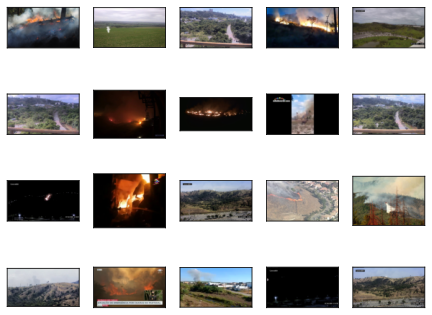

In [ ]:
# Here we are taking one batch(defined above) and visualizing its first 20 items.
d2l.set_figsize((4, 4))
for X, y in dataloader:
  print(X[0].shape)
  print(len(X))


  imgs = [i.permute(1, 2, 0)/2+0.5 for i in X[0:20]]
  for j in y[0:20]:
    print(j)
  d2l.show_images(imgs, num_rows=4, num_cols=5)
  break

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load Pretrained Faster RCNN because of the limited number of images available(training from scratch requires ideally 100k or more photos and significant resources)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 3  # Background + 2 object classes (modify accordingly)
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 234MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import torch.optim as optim
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


import torch.optim as optim

# Define optimizer, epochs and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 25

# Training

# For an epoch in a range
for epoch in range(num_epochs):
  total_loss = 0.0 # setting initial loss to 0

# Call model dot train
  model.train()

  for images, targets in dataloader:
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # Do the forward pass
    # Calculate the Loss
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    # Optimizer zero grad
    optimizer.zero_grad()

    # Losss backward
    losses.backward()

    # Optimizer step step step
    optimizer.step()

    total_loss += losses.item()

  print(f'Epoch {epoch+1} of {num_epochs}, Loss: {total_loss:.4f}')



Skipping image /content/data/train/images/AoF06348.jpg because box: [964.0, 186.00000000000003, 964.0, 186.00000000000003] proportions are invalid
Skipping image /content/data/train/images/WEB04742.jpg because box: [248.0, 177.0, 248.0, 177.0] proportions are invalid
Skipping image /content/data/train/images/AoF06456.jpg because box: [189.00000000000003, 315.0, 189.00000000000003, 315.0] proportions are invalid
Skipping image /content/data/train/images/AoF06439.jpg because box: [912.0, 198.00000000000003, 912.0, 198.00000000000003] proportions are invalid
Skipping image /content/data/train/images/WEB04243.jpg because box: [275.0, 239.99999999999997, 275.0, 239.99999999999997] proportions are invalid
Skipping image /content/data/train/images/WEB06900.jpg because box: [1093.0, 168.0, 1093.0, 168.0] proportions are invalid
Skipping image /content/data/train/images/WEB07998.jpg because box: [414.00000000000006, 166.0, 414.00000000000006, 166.0] proportions are invalid
Skipping image /conte

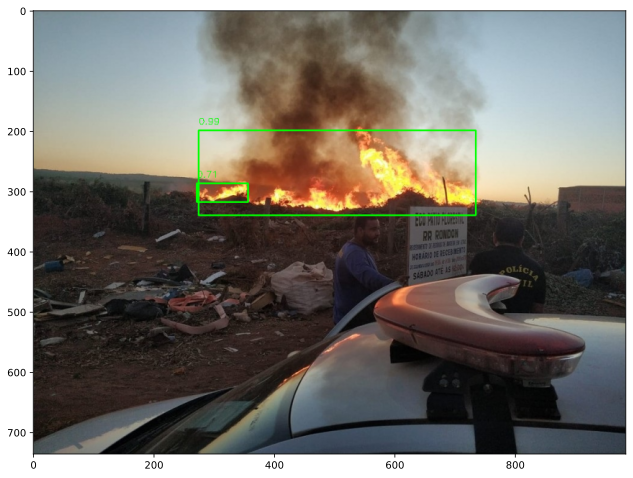

In [ ]:
import matplotlib.pyplot as plt
import cv2

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])

def visualize_prediction(model, img_path, transf=transform):
  model.eval() # setting eval mode

  image = Image.open(img_path).convert("RGB")
  # image = image.unsqueeze(0).to(device)
  image = transf(image).to(device)

  with torch.no_grad():
    predictions = model(image)[0]

  # Draw bounding boxes
  img = cv2.imread(img_path)
  for i, box in enumerate(predictions['boxes']):
    score = predictions['scores'][i].item()
    if score > 0.5:  # Confidence threshold
      x1, y1, x2, y2 = map(int, box)
      cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
      cv2.putText(img, f"{score:.2f}", (x1, y1 - 10), cv2.FONT_ITALIC, 0.5, (0, 255, 0), 1)

  plt.figure(figsize=(12, 8))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

# Inference by testing on a random image
test_image_path = Path('/content/data/test/images')
test_image_files = os.listdir(test_image_path)
random_image_file = random.choice(test_image_files)
visualize_prediction(model, f'{test_image_path}/{random_image_file}')
